In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from math import pi
from matplotlib.lines import Line2D
import tomllib
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import random
import warnings
import matplotlib as mpl

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import copy

In [2]:
def dew_point_cacl(t, h):
    """t- температура в градусах цельсия, h - влажность воздуха в виде ХХ"""
    a, b = 17.27, 237.7
    g = a * t / (b + t)
    h = np.clip(h, 1e-6, 100.0)
    g += np.log(h / 100)
    dp = (b * g) / (a - g)
    return dp

In [75]:
alldata= pd.read_feather("meteo.feather")
curent_time = alldata["datetime"].max() - pd.Timedelta(days=5)
data_timesort = alldata[alldata["datetime"] > curent_time]
# data = data_timesort[data_timesort["id_s"] == "5"].reset_index()
data = copy.copy(data_timesort).reset_index()
data["temp_air"] = data["temp_air"] + 8
data["hum_air"] = data["hum_air"] + 30

работа с toml

In [109]:
class Diseas_work:
    """
    Класс для анализа и оценки вероятности наличия заболеваний на основе параметров,
    заданных в TOML-файле. Поддерживает динамическую загрузку критериев заболевания,
    нормализацию данных, сравнение с допустимыми диапазонами и расчёт вероятности
    на основе евклидова расстояния в нормализованном пространстве параметров.
    """
    def __init__(self, file=None, coef=0):
        """
        Инициализирует экземпляр класса.

        Параметры:
        ----------
        file : str или None, по умолчанию None
            Путь к TOML-файлу с описанием заболеваний и их параметров.
        coef : float, по умолчанию 0
            Коэффициент расширения диапазонов параметров (в процентах от исходного диапазона).
        """
        self.names = []
        self.prob_last={}
        self.diseas = {}
        self.diseas_check={}
        self.time = {}
        self.valid = {}
        self.prob = {}
        if file!=None:
            self._add_diseas_toml(file, coef)

    def _add_diseas_toml(self, file, coef=0):
        """
        Загружает данные о заболеваниях из TOML-файла и инициализирует внутренние структуры.

        Параметры:
        ----------
        file : str
            Путь к TOML-файлу.
        coef : float
            Процентное расширение границ min/max для каждого параметра.
        """
        with open(file, "rb") as f:
            diseases = tomllib.load(f)
        for d_name in diseases:
            self.names.append(d_name)
            self.diseas[d_name] = pd.DataFrame(columns=("min", "max"))
            # print(d_name)
            for param in diseases[d_name]["param"]:
                if param == "time":
                    self.time[d_name] = diseases[d_name]["param"]["time"]["min"]
                else:
                    param_data = diseases[d_name]["param"][param]
                    min_val = param_data.get("min", 1e-6)
                    max_val = param_data.get("max", 1e6)
                    delta = (max_val - min_val) / 100 * coef
                    self.diseas[d_name].loc[param] = [min_val - delta, max_val + delta]
                    

    def _calc_prob(self,data, param_val, time):
        """
        Рассчитывает вероятность наличия заболевания на основе нормализованных данных
        и евклидова расстояния до «идеальной» точки (максимально соответствующей критериям).

        Параметры:
        ----------
        data : pandas.DataFrame
            Данные пациента с флагом 'check', указывающим на попадание в допустимый диапазон.
        param_val : pandas.DataFrame
            Границы (min, max) для каждого параметра заболевания.
        time : float
            Максимальная продолжительность (в часах), используемая как нормирующий масштаб.

        Возвращает:
        ----------
        pandas.Series
            Серия с вероятностями (в процентах) для каждой записи в data.
        """
        data=data[data['check']==True]
        param_val.loc['time']=[0,time*3600]
        # Нормализуем каждый параметр в диапазон [0, 1]
        df_norm = pd.DataFrame()
        for index, (low, high) in param_val.T.items():
            if index=='time':
                df_norm[index] =data[index] 
            else:
                df_norm[index] = (data[index] - low) / (high - low)
        data_mas = df_norm.to_numpy()
        # Опорная точка "идеального" состояния: все параметры = 0, кроме времени = time*3600
        m_v = [*[0]*len(param_val)]
        a_v = [*[0]*(len(param_val)-1), time*3600]
        b = np.array([a_v] * len(data_mas))
        # Вычисляем евклидово расстояние от каждой точки до целевой точки a_v
        l = np.linalg.norm(data_mas - b, axis=1)
        # Максимально возможное расстояние: от m_v до a_v
        ml = np.linalg.norm(np.array(m_v) - np.array(a_v))
        # Нормированная вероятность: 1 - (текущее расстояние / максимальное)
        # Преобразуем в проценты и упаковываем в Series с исходными индексами
        prob = 1 - l / ml
        prob= pd.Series( prob*100,index=data.index,name='prob')
        # Обнуляем крайне малые вероятности
        prob[prob<0.01]=0
        # Коррекция для длительных эпизодов: если время >= 1 интервал (time*3600),
        # вероятность растёт линейно: 100% + (n - 1)*100% - (остаток от исходной вероятности)
        for i in prob.index:
            c=data.loc[i,'time'] //(time*3600)
            if c>=1:
                prob[i]=100+c*100-prob[i]
        return prob

    def _compair_values(self, data, diseas_name):
        """
        Сравнивает входные данные с диапазонами параметров для указанного заболевания,
        определяет валидные интервалы и рассчитывает вероятность.

        Параметры:
        ----------
        data : pandas.DataFrame
            Входные данные с колонкой 'datetime'.
        diseas_name : str
            Название заболевания из загруженного TOML-файла.

        Возвращает:
        ----------
        pandas.DataFrame
            Расширенный DataFrame с колонками 'check', 'time', 'prob' и др.
        """
        df_range = copy.copy(self.diseas[diseas_name])
        time_sec=self.time[diseas_name] * 3600
        df_values = copy.copy(data)
        common_params = df_values.columns.intersection(df_range.index)
        df_values = df_values[common_params]
        df_range = df_range.reindex(common_params)
        valid = (df_values >= df_range["min"]) & (df_values <= df_range["max"])
        valid.columns = valid.columns + "_c"
        valid["check"] = valid.all(axis=1)
        valid["datetime"] = data["datetime"]
        
        if valid["check"].any()==True:
            valid["time_delta"] = valid["datetime"].diff().dt.total_seconds()
            mask = valid["check"]
            groups = (~mask).cumsum()
            valid["time"] = valid.loc[mask, "time_delta"].groupby(groups[mask]).cumsum()
            valid["time"] = valid["time"].fillna(0)
            valid.loc[valid["time"] > time_sec, "time"] = time_sec/2
            valid = pd.concat([valid, df_values], axis=1)

            prob=self._calc_prob(valid,df_range,self.time[diseas_name])
            valid=pd.concat([valid,prob], axis=1)
            valid["prob"] = valid["prob"].fillna(0)
        else:
            valid['prob']=0
        return valid

    def check_time(self, data:pd.DataFrame, time="last_hour"):
        """
        Анализирует данные за указанный временной интервал и обновляет внутренние
        атрибуты класса: вероятности, флаги наличия заболевания и временные ряды.

        Параметры:
        ----------
        data : pandas.DataFrame
            Входные данные с обязательной колонкой 'datetime'.
        time : str или int, по умолчанию "last_hour"
            Временной интервал анализа:
            - "last_hour": последний час;
            - "all": все данные;
            - int: последние N часов.
        """
        if time == "last_hour":
            time_last = data["datetime"].max()- pd.Timedelta(hours=1)
        elif time == "all":
            time_last = data["datetime"].min()
        else:
            time_last = data["datetime"].max() - pd.Timedelta(hours=time)
        data_last = data[data["datetime"] >= time_last]
        for d_name in self.names:
            # print("check ", d_name)
            # print(self.diseas[d_name])
            self.valid[d_name] = self._compair_values(data_last, d_name)
            
            self.prob_last[d_name]=self.valid[d_name]['prob'].iloc[-1]
            self.diseas_check[d_name]=self.valid[d_name]['prob'].any()
            self.prob[d_name]=self.valid[d_name].loc[:,['datetime','prob']]
            # print(' ',self.current[d_name])

In [107]:
d = Diseas_work("haze.toml", 20)
d.check_time(data,7*24)


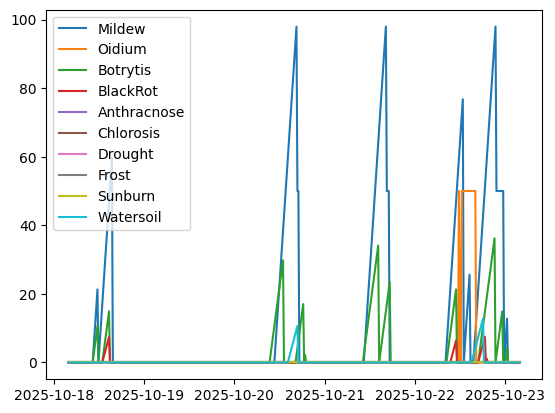

{'Mildew': np.float64(0.0), 'Oidium': np.float64(0.0), 'Botrytis': np.float64(0.0), 'BlackRot': np.float64(0.0), 'Anthracnose': np.int64(0), 'Chlorosis': np.int64(0), 'Drought': np.int64(0), 'Frost': np.int64(0), 'Sunburn': np.int64(0), 'Watersoil': np.float64(0.0)}


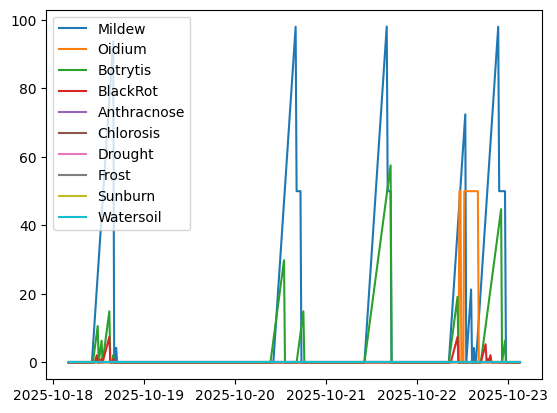

{'Mildew': np.float64(0.0), 'Oidium': np.float64(0.0), 'Botrytis': np.float64(0.0), 'BlackRot': np.float64(0.0), 'Anthracnose': np.int64(0), 'Chlorosis': np.int64(0), 'Drought': np.int64(0), 'Frost': np.int64(0), 'Sunburn': np.int64(0), 'Watersoil': np.int64(0)}


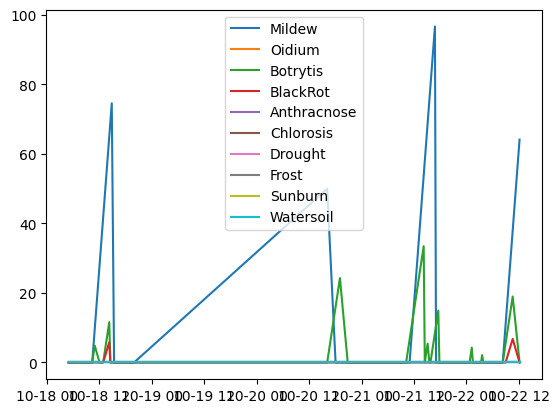

{'Mildew': np.float64(64.14351834887442), 'Oidium': np.int64(0), 'Botrytis': np.float64(0.0), 'BlackRot': np.float64(0.0), 'Anthracnose': np.int64(0), 'Chlorosis': np.int64(0), 'Drought': np.int64(0), 'Frost': np.int64(0), 'Sunburn': np.int64(0), 'Watersoil': np.int64(0)}


In [113]:
d = Diseas_work("haze.toml", 20)
for id in data['id_s'].unique():
   
    
    d.check_time(data[data['id_s']==id],7*24)
    plt.figure()
    for d_name in d.names:
       
        plt.plot(d.prob[d_name]['datetime'],d.prob[d_name]['prob'],label=d_name)
        # plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close()
    print(d.prob_last)

In [49]:
# Отключить перенос строк и ограничения на ширину
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

for d_name in d.names:
    print(d_name)
    print(d.valid[d_name])
    print("")

Mildew
      temp_air_c  hum_air_c  check            datetime  prob
1062       False      False  False 2025-10-23 03:02:48     0
1063       False      False  False 2025-10-23 03:04:00     0
1064        True      False  False 2025-10-23 03:50:08     0

Oidium
      temp_air_c  hum_air_c  check            datetime  prob
1062       False      False  False 2025-10-23 03:02:48     0
1063       False      False  False 2025-10-23 03:04:00     0
1064       False      False  False 2025-10-23 03:50:08     0

Botrytis
      temp_air_c  hum_air_c  check            datetime  prob
1062        True      False  False 2025-10-23 03:02:48     0
1063        True      False  False 2025-10-23 03:04:00     0
1064        True      False  False 2025-10-23 03:50:08     0

BlackRot
      temp_air_c  hum_air_c  check            datetime  prob
1062       False      False  False 2025-10-23 03:02:48     0
1063       False      False  False 2025-10-23 03:04:00     0
1064       False      False  False 2025-10-23 03:5